In [1]:
import django, os, sys, time, resource, re, gc, shutil
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from django.db.models import Count, Avg, F
import difflib


sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')

os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from scoping.models import *

In [2]:
p = Project.objects.get(title="NETs")
pdocs = Doc.objects.filter(query__project=p) | Doc.objects.filter(technology__project=p)

trdocs = set(list(pdocs.filter(docownership__relevant=1).values_list('UT',flat=True)))

irdocs = set(list(pdocs.filter(docownership__relevant=5).values_list('UT',flat=True)))

inrateddocs = set(list(pdocs.filter(docownership__relevant__in=[5,6,7,8]).values_list('UT',flat=True)))


In [3]:
print(len(trdocs))
print(len(irdocs))
print(len(inrateddocs))

print(len(trdocs.intersection(inrateddocs)))

alltdocs = pdocs.distinct().filter(
    UT__in=trdocs
)

allreldocs = pdocs.distinct().filter(
    UT__in=trdocs.intersection(irdocs)
)

alliratdocs = pdocs.distinct().filter(
    UT__in=trdocs.intersection(inrateddocs)
)

print(allreldocs.count())

2640
1792
2399
904
682


In [4]:
print(alliratdocs.count())

dos_g = DocOwnership.objects.filter(doc__in=alliratdocs,user__username="nemet",relevant__gt=0).order_by('query','doc')
dos_s = DocOwnership.objects.filter(doc__in=alliratdocs,user__username="rogers",relevant__gt=0).order_by('query','doc')

print(dos_g.count())

print(dos_s.count())

gscores = []
sscores = []

agrees = 0
disagrees = 0

for s in dos_s:
    g = dos_g.filter(query=s.query,doc=s.doc)
    if g.count() > 0:
        if g.count() > 1:
            print(g.count())
        g = g.first().relevant
    else:
        continue
        g = None
    gscores.append(g)
    sscores.append(s.relevant)
    if g == s.relevant:
        agrees+=1
    else:
        disagrees+=1



agreement = round(difflib.SequenceMatcher(None,gscores,sscores).ratio(),2)

agreement


904
1742
928


0.01

In [5]:
print(agrees)
print(disagrees)

749
175


In [6]:
difflib.SequenceMatcher(None,gscores[0:250],sscores[0:250]).ratio()

0.016

In [7]:
difflib.SequenceMatcher(None,[1,2,3],[1,2]).ratio()

0.8

In [8]:
len(gscores)
len(sscores)

924

In [9]:
allidocs = allreldocs.filter(
    docownership__relevant=5,
).values('PY','docownership__query__innovation__name').annotate(
    n = Count('pk', distinct = True)
)
df = pd.DataFrame.from_dict(list(allidocs))
df.head()

,PY,docownership__query__innovation__name,n
0,2007,RD,21
1,2012,Scaleup,20
2,2006,Scaleup,6
3,2004,RD,11
4,2013,Scaleup,24


     PY docownership__query__innovation__name    n
0  1990                            Demandpull  0.0
1  1990                                 Demos  0.0
2  1990                          Nichemarkets  0.0
3  1990                          Publicaccept  0.0
4  1990                                    RD  0.0
      PY docownership__query__innovation__name     n
46  1997                                    RD   3.0
82  2003                                    RD   7.0
94  2005                                    RD  22.0
28  1994                                    RD   2.0
34  1995                                    RD   3.0


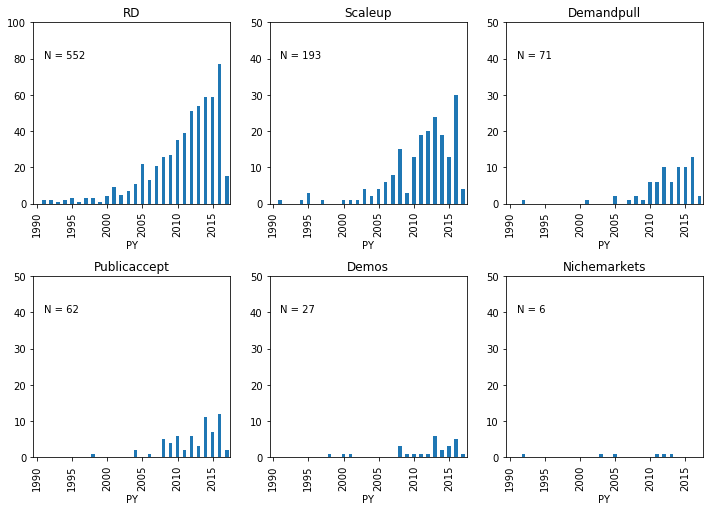

In [10]:
plt.rcParams["figure.figsize"] = [12,8]

fig, axs = plt.subplots(nrows=2,ncols=3,gridspec_kw=dict(hspace=0.4))

pt = pd.pivot_table(
    df,
    values='n',
    columns=['PY'],
    index=['docownership__query__innovation__name'],
    fill_value=0
)

fullindex = pd.DatetimeIndex(freq='1A', start='1974', end='2017')

pt = (
    df.set_index(['PY','docownership__query__innovation__name'])
        .unstack(level='docownership__query__innovation__name')
        .reindex(range(1990,2018))
        .fillna(0)
        .stack()
        .reset_index()
)

print(pt.head())

iorder = [
    "RD",
    "Scaleup",
    "Demandpull",
    "Publicaccept",
    "Demos",
    "Nichemarkets"
]


pt['docownership__query__innovation__name'] = pd.Categorical(pt['docownership__query__innovation__name'],iorder)

pt = pt.sort_values(['docownership__query__innovation__name'])

print(pt.head())


grouped =  pt.groupby('docownership__query__innovation__name')

#grouped = grouped.sort_values('docownership__query__innovation__name')

targets = zip(iorder, axs.flatten())

n = 5

for i, (key, ax) in enumerate(targets):
    
    group = grouped.get_group(key)
    
    group = group.sort_values('PY')
    group = group.set_index('PY')
    group.plot.bar(ax=ax, legend=False)
    #ax.bar(group.index,group['n'])
    #ax.bar(group,group[['n']])
    
    ticks = ax.xaxis.get_ticklocs()
    ticklabels = [l.get_text() for l in ax.xaxis.get_ticklabels()]
    ax.xaxis.set_ticks(ticks[::n])
    ax.xaxis.set_ticklabels(ticklabels[::n])
    
    if key=="RD":   
        m = 100
    else:   
        m = 50
        
    ax.set_ylim(0,m)
    
    
    ax.set_title(key)
    
    s = "N = {:d}".format(int(group.sum()['n']))
    
    ax.text(1,m*0.8, s)
    

plt.savefig('plots/1_1_1.png',bbox_inches='tight') 
plt.show()

In [11]:
allds = allreldocs.filter(
    docownership__relevant__in=[5,1],
).values(
    'docownership__query__innovation__name',
    'docownership__query__technology__name',
    'PY'
).annotate(
    n = Count('pk', distinct = True)
)
lallds = list(allds)
lallds.append({
    "PY":1990,
    "docownership__query__innovation__name": "Scaleup",
    "docownership__query__technology__name": "Afforestation/reforestation",
    "n": 0
})
adf = pd.DataFrame.from_dict(lallds)
adf = adf[adf['docownership__query__innovation__name'] != "None"]
adf.sort_values('PY').head()

,PY,docownership__query__innovation__name,docownership__query__technology__name,n
394,1990,Scaleup,Afforestation/reforestation,0
232,1991,Scaleup,Afforestation/reforestation,1
293,1991,None,Afforestation/reforestation,2
326,1991,RD,Afforestation/reforestation,2
97,1992,None,Afforestation/reforestation,2


In [12]:
reindexes = [
    ('PY','docownership__query__technology__name','docownership__query__innovation__name'),
    ('PY','docownership__query__innovation__name','docownership__query__technology__name'),
    ('docownership__query__innovation__name','docownership__query__technology__name','PY')
]

pt = adf

for x in reindexes:

    pt = pd.pivot_table(
        pt,
        values='n',
        columns=[x[2]],
        index=[x[0],x[1]],
        fill_value=0
    ).reset_index()


    pt = pd.melt(
        pt,
        id_vars=[x[0],x[1]],
        value_name='n'
    ).reset_index()

pt['docownership__query__innovation__name'] = pd.Categorical(pt['docownership__query__innovation__name'],
                                                            [
                                                                "RD",
                                                                "Scaleup",
                                                                "Demandpull",
                                                                "Publicaccept",
                                                                "Demos",
                                                                "Nichemarkets"
                                                            ])

pt = pt.sort_values(['PY','docownership__query__innovation__name'])


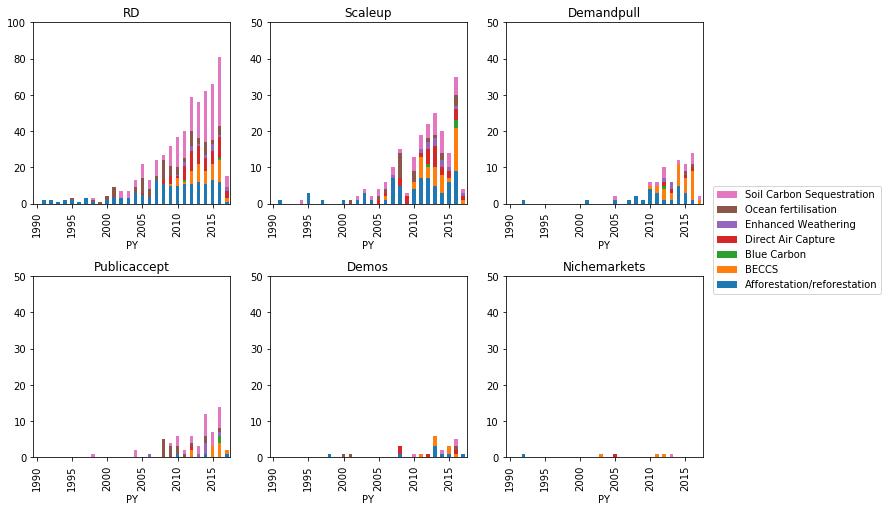

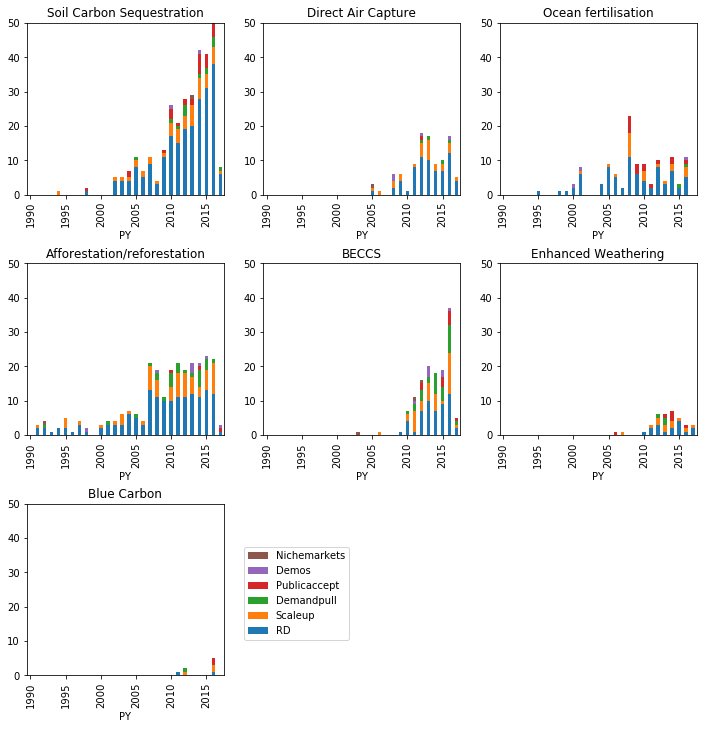

In [13]:
groupings = [
    ('docownership__query__innovation__name','docownership__query__technology__name',2),
    ('docownership__query__technology__name','docownership__query__innovation__name',3),
]


for x in groupings:
    
    plt.rcParams["figure.figsize"] = [12,4*x[2]]
    
    grouped = pt.groupby(x[0])

    fig, axs = plt.subplots(nrows=x[2],ncols=3,gridspec_kw=dict(hspace=0.4))
    targets = zip(grouped.groups.keys(), axs.flatten())
    
    if x[2]==2:
        targets = zip(iorder, axs.flatten())

    for i, (key, ax) in enumerate(targets):
        try:
            group = grouped.get_group(key)
            group = group.sort_values('PY')

            table = pd.pivot_table(
                group,
                values='n',
                columns=[x[1]],
                index=['PY']
            )

            table.plot.bar(ax=ax,stacked=True,legend=False,title=key)
            
            #l = ax.legend()

            if i == 0:
                #ax.legend()
                handles, labels = ax.get_legend_handles_labels()
            
            ticks = ax.xaxis.get_ticklocs()
            ticklabels = [l.get_text() for l in ax.xaxis.get_ticklabels()]
            ax.xaxis.set_ticks(ticks[::n])
            ax.xaxis.set_ticklabels(ticklabels[::n])
            
            if key=="RD":   
                m = 100
            else:   
                m = 50
        
            ax.set_ylim(0,m)
            
            
        except:
            print(key)
            print(group)
            pass

    #plt.legend()
    #ax = fig.add_axes([0.1, 0.1, 0.6, 0.75])
    #fig.subplots_adjust(right=0.65)
    if x[2]==3:
        lpos = (1.1,0.75)
        axs[-1,-1].axis('off')
        axs[-1,-2].axis('off')
    else:
        lpos = (1.05,1.5)
    ax.legend(reversed(handles), reversed(labels),bbox_to_anchor=lpos, loc=2, borderaxespad=.0,)
    plt.savefig('plots/1_1_{}.png'.format(x[2]),bbox_inches='tight') 
    plt.show()

In [14]:
tdocs = allreldocs.filter(
    docownership__relevant=1,
    docownership__query__technology__name__isnull=False,
).exclude(
    docownership__query__technology__name="Ethics & Morals"
).values(
    'docownership__query__technology__name',
    'UT',
    'PY'
)
techdocs = pd.DataFrame.from_dict(list(tdocs))


In [15]:
idocs = allreldocs.filter(
    docownership__relevant=5
).values(
    'docownership__query__innovation__name',
    'UT',
    'PY'
)
indocs = pd.DataFrame.from_dict(list(idocs))


In [16]:
irdocs = alliratdocs.filter(

).values(
    'docownership__query__innovation__name',
    'UT',
    'PY'
)
irdocs = pd.DataFrame.from_dict(list(irdocs))

irdocs = irdocs[irdocs['docownership__query__innovation__name'] != "Innovationgeneral"]

print(len(irdocs))

print(len(irdocs.drop_duplicates()))

print(irdocs.head())


2592
2592
     PY                   UT docownership__query__innovation__name
0  2007  WOS:000246970400010                            Demandpull
1  2005  WOS:000228902700004                                    RD
2  2016  WOS:000388827100001                                  None
3  2012  WOS:000307462300012                                  None
4  2013  WOS:000323530900093                               Scaleup


In [17]:
alldocs = techdocs.merge(indocs,how="outer")
allrateddocs = techdocs.merge(irdocs, how="outer")

print(len(alldocs))

print(len(allrateddocs))




alldocs.sort_values('UT').head()

1040
2832


,PY,UT,docownership__query__technology__name,docownership__query__innovation__name
800,1998,WOS:000073319700018,Soil Carbon Sequestration,RD
0,1998,WOS:000074762000009,Afforestation/reforestation,RD
1,1998,WOS:000074762000009,Afforestation/reforestation,Demos
801,1998,WOS:000075594000003,Soil Carbon Sequestration,Publicaccept
683,1998,WOS:000076946500004,Ocean fertilisation,RD


In [18]:
allrateddocs.head()

,PY,UT,docownership__query__technology__name,docownership__query__innovation__name
0,1998,WOS:000074762000009,Afforestation/reforestation,RD
1,1998,WOS:000074762000009,Afforestation/reforestation,Demos
2,1998,WOS:000074762000009,Afforestation/reforestation,None
3,2000,WOS:000085928300039,Afforestation/reforestation,None
4,2000,WOS:000085928300039,Afforestation/reforestation,RD


In [19]:
def fix_table(df):
    table = df.groupby(['docownership__query__technology__name','docownership__query__innovation__name'])
    table = table.count()
    table = table.reset_index()
    table = table.rename(columns={'UT':'n'})
    table = table.drop('PY',1)

    table = pd.pivot_table(
            table,
            values='n',
            index=['docownership__query__technology__name'],
            columns=['docownership__query__innovation__name'],
            fill_value=0
        ).reset_index()

    #table.index.rename('index',True)
    print(table.columns)
    
    table.columns = ['Technology','Demandpull','Demos','Nichemarkets','Publicaccept','RD','Scaleup']

    table = table[['Technology','RD','Demos','Scaleup','Demandpull','Nichemarkets','Publicaccept']]

    table['Total'] = table.sum(axis=1,numeric_only=True)
    return(table)
    
table = fix_table(alldocs)

basic_table = table

allratedtable = fix_table(allrateddocs)

def get_ttotal(i):
    x = allreldocs.filter(
        docownership__query__technology__name=i['Technology'],
        docownership__relevant=1
    ).distinct().count()
    if x == 0:
        x = np.NaN
    return(x)

def get_itotal(i):
    x = allreldocs.filter(
        docownership__query__innovation__name=i.name,
        docownership__relevant=5
    ).distinct().count()
    if x == 0:
        x = np.NaN
    return(x)

def get_irattotal(i):
    x = alliratdocs.filter(
        docownership__query__technology__name=i['Technology']
    ).distinct().count()
    if x == 0:
        x = np.NaN
    return(x)

def get_ttotal_all(i):
    x = alltdocs.filter(
        docownership__query__technology__name=i['Technology'],
        docownership__relevant=1
    ).distinct().count()
    return(x)

table['distinct_Total'] = table.apply(lambda x: get_ttotal(x), axis=1)

table['distinct_anyrating_Total'] = table.apply(lambda x: get_irattotal(x), axis=1)

table['distinct_alltech_Total'] = table.apply(lambda x: get_ttotal_all(x), axis=1)

table.set_index('Technology',inplace=True)

table.loc['Total'] = table.sum()

table.loc['distinct_Total'] = table.apply(lambda x: get_itotal(x))


table.head(15)

#table.sum(axis=0,numeric_only=True)

Index(['docownership__query__technology__name', 'Demandpull', 'Demos',
       'Nichemarkets', 'Publicaccept', 'RD', 'Scaleup'],
      dtype='object', name='docownership__query__innovation__name')
Index(['docownership__query__technology__name', 'Demandpull', 'Demos',
       'Nichemarkets', 'Publicaccept', 'RD', 'Scaleup'],
      dtype='object', name='docownership__query__innovation__name')


,RD,Demos,Scaleup,Demandpull,Nichemarkets,Publicaccept,Total,distinct_Total,distinct_anyrating_Total,distinct_alltech_Total
Technology,,,,,,,,,,
Afforestation/reforestation,142.0,9.0,63.0,25.0,1.0,7.0,247.0,186.0,260.0,475.0
BECCS,48.0,7.0,34.0,27.0,3.0,8.0,127.0,78.0,115.0,216.0
Biochar,47.0,1.0,15.0,4.0,1.0,5.0,73.0,55.0,71.0,87.0
Blue Carbon,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,9.0,2.0
Direct Air Capture,66.0,5.0,24.0,4.0,0.0,2.0,101.0,80.0,117.0,221.0
Enhanced Weathering,12.0,1.0,7.0,1.0,0.0,5.0,26.0,18.0,31.0,33.0
Geological Storage,1.0,0.0,1.0,1.0,0.0,1.0,4.0,1.0,1.0,133.0
Ocean Alkalinisation,4.0,0.0,5.0,2.0,0.0,2.0,13.0,9.0,10.0,18.0
Ocean fertilisation,72.0,4.0,21.0,3.0,0.0,13.0,113.0,80.0,92.0,200.0


In [20]:
ttable = allratedtable

ttable.head()

,Technology,RD,Demos,Scaleup,Demandpull,Nichemarkets,Publicaccept,Total
0,Afforestation/reforestation,142,13,80,43,3,86,367
1,BECCS,48,17,54,52,3,41,215
2,Biochar,47,9,21,9,1,22,109
3,Blue Carbon,1,0,0,0,0,0,1
4,Direct Air Capture,66,22,36,11,1,17,153


In [21]:
rtable = table

rtable = rtable.drop(['Total','distinct_Total','distinct_anyrating_Total'],1)

for col in rtable.columns:

    rtable[col] = rtable[col]/rtable['distinct_alltech_Total']*100
    


rtable.head()

,RD,Demos,Scaleup,Demandpull,Nichemarkets,Publicaccept,distinct_alltech_Total
Technology,,,,,,,
Afforestation/reforestation,29.894737,1.894737,13.263158,5.263158,0.210526,1.473684,100.0
BECCS,22.222222,3.240741,15.740741,12.500000,1.388889,3.703704,100.0
Biochar,54.022989,1.149425,17.241379,4.597701,1.149425,5.747126,100.0
Blue Carbon,50.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100.0
Direct Air Capture,29.864253,2.262443,10.859729,1.809955,0.000000,0.904977,100.0


In [22]:
basic_table = fix_table(alldocs)
basic_table = basic_table.set_index('Technology')

basic_table.head()

Index(['docownership__query__technology__name', 'Demandpull', 'Demos',
       'Nichemarkets', 'Publicaccept', 'RD', 'Scaleup'],
      dtype='object', name='docownership__query__innovation__name')


,RD,Demos,Scaleup,Demandpull,Nichemarkets,Publicaccept,Total
Technology,,,,,,,
Afforestation/reforestation,142,9,63,25,1,7,247
BECCS,48,7,34,27,3,8,127
Biochar,47,1,15,4,1,5,73
Blue Carbon,1,0,0,0,0,0,1
Direct Air Capture,66,5,24,4,0,2,101


In [23]:
allratedtable = fix_table(allrateddocs).set_index('Technology')
allratedtable.head()

Index(['docownership__query__technology__name', 'Demandpull', 'Demos',
       'Nichemarkets', 'Publicaccept', 'RD', 'Scaleup'],
      dtype='object', name='docownership__query__innovation__name')


,RD,Demos,Scaleup,Demandpull,Nichemarkets,Publicaccept,Total
Technology,,,,,,,
Afforestation/reforestation,142,13,80,43,3,86,367
BECCS,48,17,54,52,3,41,215
Biochar,47,9,21,9,1,22,109
Blue Carbon,1,0,0,0,0,0,1
Direct Air Capture,66,22,36,11,1,17,153


In [24]:
rtable2 = basic_table/allratedtable*100
rtable2 = rtable2.fillna(0)
rtable2

,RD,Demos,Scaleup,Demandpull,Nichemarkets,Publicaccept,Total
Technology,,,,,,,
Afforestation/reforestation,100.0,69.230769,78.750000,58.139535,33.333333,8.139535,67.302452
BECCS,100.0,41.176471,62.962963,51.923077,100.000000,19.512195,59.069767
Biochar,100.0,11.111111,71.428571,44.444444,100.000000,22.727273,66.972477
Blue Carbon,100.0,0.000000,0.000000,0.000000,0.000000,0.000000,100.000000
Direct Air Capture,100.0,22.727273,66.666667,36.363636,0.000000,11.764706,66.013072
Enhanced Weathering,100.0,50.000000,77.777778,100.000000,0.000000,62.500000,81.250000
Geological Storage,100.0,0.000000,100.000000,100.000000,0.000000,100.000000,100.000000
Ocean Alkalinisation,100.0,0.000000,100.000000,100.000000,0.000000,33.333333,76.470588
Ocean fertilisation,100.0,57.142857,61.764706,42.857143,0.000000,54.166667,77.931034


In [25]:
itable = table

itable = itable.drop(['Total','distinct_Total','distinct_alltech_Total','distinct_anyrating_Total'],1)

for col in itable.columns:

    itable[col] = itable[col]/itable['RD']*100
    


itable.head()


,RD,Demos,Scaleup,Demandpull,Nichemarkets,Publicaccept
Technology,,,,,,
Afforestation/reforestation,100.0,9.0,63.0,25.0,1.0,7.0
BECCS,100.0,7.0,34.0,27.0,3.0,8.0
Biochar,100.0,1.0,15.0,4.0,1.0,5.0
Blue Carbon,100.0,0.0,0.0,0.0,0.0,0.0
Direct Air Capture,100.0,5.0,24.0,4.0,0.0,2.0


In [26]:
writer = pd.ExcelWriter('tables/tech_innov_totals.xlsx')
table.to_excel(writer,'Relevant Documents')
rtable.to_excel(writer,'% Relevant of Technology')
rtable2.to_excel(writer,'% Relevant of Technology rated')
itable.to_excel(writer, '% Stage')
ttable.to_excel(writer,'Any Rating Totals')
writer.save()

In [27]:
pt = pt[pt['docownership__query__technology__name']!="Blue Carbon"]
pt = pt[pt['docownership__query__technology__name']!="Geological Storage"]
pt = pt[pt['docownership__query__technology__name']!="Ocean Alkalinisation"]

In [28]:
alldocs = alldocs[alldocs['docownership__query__technology__name']!="Blue Carbon"]
alldocs = alldocs[alldocs['docownership__query__technology__name']!="Geological Storage"]
alldocs = alldocs[alldocs['docownership__query__technology__name']!="Ocean Alkalinisation"]

byyear = alldocs.groupby(['PY','docownership__query__technology__name','docownership__query__innovation__name'])
byyear = byyear.count()
byyear = byyear.reset_index()
byyear = byyear.fillna(0)
byyear = byyear.rename(columns={'UT':'n'})


byyear.head()

,PY,docownership__query__technology__name,docownership__query__innovation__name,n
0,1991,Afforestation/reforestation,RD,2
1,1991,Afforestation/reforestation,Scaleup,1
2,1992,Afforestation/reforestation,Demandpull,1
3,1992,Afforestation/reforestation,Nichemarkets,1
4,1992,Afforestation/reforestation,RD,2


In [29]:
### Prepare Byyears, extend indexes
reindexes = [
    ('PY','docownership__query__technology__name','docownership__query__innovation__name'),
    ('PY','docownership__query__innovation__name','docownership__query__technology__name'),
    ('docownership__query__innovation__name','docownership__query__technology__name','PY')
]

pt = byyear

for x in reindexes:

    pt = pd.pivot_table(
        pt,
        values='n',
        columns=[x[2]],
        index=[x[0],x[1]],
        fill_value=0
    ).reset_index()


    pt = pd.melt(
        pt,
        id_vars=[x[0],x[1]],
        value_name='n'
    ).reset_index()

pt['docownership__query__innovation__name'] = pd.Categorical(pt['docownership__query__innovation__name'],
                                                            [
                                                                "RD",
                                                                "Demos",
                                                                "Scaleup",
                                                                "Demandpull",                                                             
                                                                "Nichemarkets",
                                                                "Publicaccept"
                                                            ])

pt = pt.sort_values(['PY','docownership__query__innovation__name'])

In [30]:
iorder =[
    "RD",
    "Demos",
    "Scaleup",
    "Demandpull",                                                             
    "Nichemarkets",
    "Publicaccept"
]

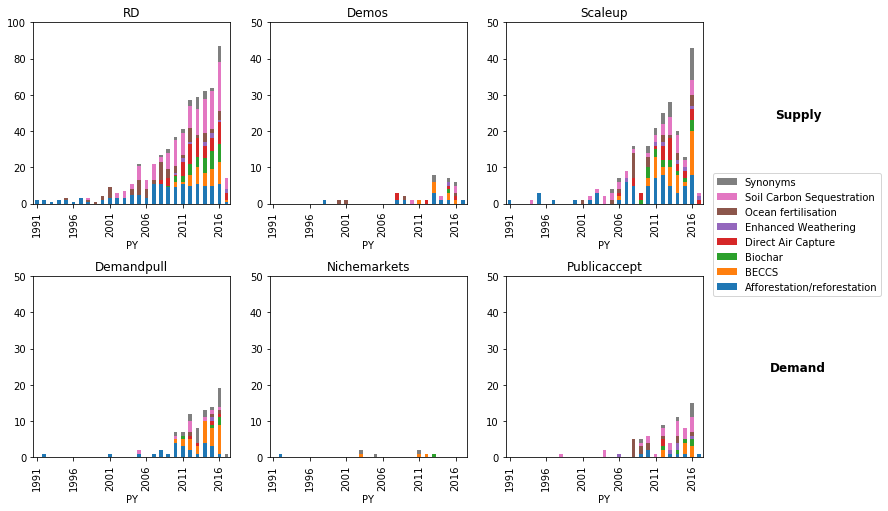

In [31]:
groupings = [
    ('docownership__query__innovation__name','docownership__query__technology__name',2),
    #('docownership__query__technology__name','docownership__query__innovation__name',4),
]


for x in groupings:
    
    plt.rcParams["figure.figsize"] = [12,4*x[2]]
    
    grouped = pt.groupby(x[0])

    fig, axs = plt.subplots(nrows=x[2],ncols=3,gridspec_kw=dict(hspace=0.4))
    targets = zip(grouped.groups.keys(), axs.flatten())
    
    if x[2]==2:
        targets = zip(iorder, axs.flatten())
        

    for i, (key, ax) in enumerate(targets):
        try:
            group = grouped.get_group(key)
            group = group.sort_values('PY')

            table = pd.pivot_table(
                group,
                values='n',
                columns=[x[1]],
                index=['PY']
            )

            table.plot.bar(ax=ax,stacked=True,legend=False,title=key, sort_columns=True)
            
            #l = ax.legend()

            if i == 0:
                #ax.legend()
                handles, labels = ax.get_legend_handles_labels()
            
            ticks = ax.xaxis.get_ticklocs()
            ticklabels = [l.get_text() for l in ax.xaxis.get_ticklabels()]
            ax.xaxis.set_ticks(ticks[::n])
            ax.xaxis.set_ticklabels(ticklabels[::n])
            
            if key=="RD":   
                m = 100
            else:   
                m = 50
        
            ax.set_ylim(0,m)
            
            
        except:
            print(key)
            print(group)
            pass

    #plt.legend()
    #ax = fig.add_axes([0.1, 0.1, 0.6, 0.75])
    #fig.subplots_adjust(right=0.65)
    if x[2]==4:
        lpos = (1.1,0.75)
        axs[-1,-1].axis('off')
        axs[-1,-2].axis('off')
    else:
        lpos = (1.05,1.57)
    ax.legend(reversed(handles), reversed(labels),bbox_to_anchor=lpos, loc=2, borderaxespad=.0,)
    if x[2]==4:
        f = 3
    else:
        f = 2
        fp = matplotlib.font_manager.FontProperties(weight="demibold", size="large")
        fig.text(1.01,0.72,"Supply",va="center", ha="center", fontproperties=fp)
        fig.text(1.01,0.28,"Demand",va="center", ha="center", fontproperties=fp)
    plt.savefig('plots/1_1_{}_2.png'.format(f),bbox_inches='tight') 
    plt.show()